- setup for this presentation:

~~~
jupyter nbconvert rg-presentation.ipynb --to slides --post serve
~~~
- or using RISE 
~~~
conda install -c conda-forge rise
jupyter-nbextension install rise --py --sys-prefix
~~~
then clicking on the RISE-icon on top of the notebook

In [1]:
%%HTML
<style>
.rise-enabled .CodeMirror {
    font-size:0.5em;

}

.rise-enabled .container {
    width: 90% !important;
}

.rise-enabled .rendered_html {
  font-size:0.8em;
}
.rise-enabled .rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
</style>

In [2]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [51]:
import sys
sys.path.insert(0,"../")
import pypillometry as pp
import numpy as np
import pandas as pd
import pylab as plt
import scipy
import scipy.signal as signal
from scipy.stats import pearsonr
import itertools
from joblib import Parallel, delayed
from IPython.utils import io
import plotnine as gg
import os

def load_isabel(subj,block):
    filetemplate="/scratch/cogneuro/isabel_pupil_experiment/data/block_{block}/{subj}_b{block}_samples_int.csv"
    fs=500
    fname=filetemplate.format(subj=subj,block=block)
    data=pd.read_csv(fname)
    #data[~data.MSG.isnull()]
    stim_events=np.array(data["Task.time"][data.MSG.str.startswith("MSG_outcome") & ~data.MSG.isnull()])
    resp_events=np.array(data["Task.time"][data.MSG.str.startswith("MSG_prediction") & ~data.MSG.isnull()])
    event_onsets=np.concatenate([stim_events, resp_events])
    tx=np.array(data["Task.time"])#/1000.
    sy=np.array(data["P_area_int2"])
    d=pp.PupilData(sy, time=tx, event_onsets=event_onsets, name="%s_%i"%(subj,block))
    return d

subj="39451"
block=1
d=load_isabel(subj,block)

# use only 2 mins for speed for now
dat=d.sub_slice(start=5*60*1000, end=7*60*1000, units="ms")

import warnings
warnings.filterwarnings('ignore')



# Estimation of tonic and phasic pupillometric signals

![](../logo/pypillometry_logo_200x200.png)

Matthias Mittner

pupil-symposium, 6.2.2020

Universitetet i Tromsø

## Why pupillometry?

![](stuff/mahot/svg/eye.svg)
![](stuff/mahot/svg/muscles.svg)  

<!--![](stuff/mahot/svg/anatomy.svg)-->

pupil changes size in response to
- change in lighting conditions
- near-fixation
- arousal, mental effort, ...?

<center><img src="stuff/mahot/svg/pathways.svg" width=60%></center>

<font size="-1">
(figure: Mathot, S. (2018). Pupillometry: Psychology, Physiology, and Function. Journal of Cognition, 1(1), 16. DOI: http://doi.org/10.5334/joc.18)
</font>

![](stuff/mahot/svg/lightresponse.svg)  

<font size="-1">
(figure: Mathot, S. (2018). Pupillometry: Psychology, Physiology, and Function. Journal of Cognition, 1(1), 16. DOI: http://doi.org/10.5334/joc.18)
</font>

![](stuff/mahot/svg/nearresponse.svg) 

<font size="-1">
(figure: Mathot, S. (2018). Pupillometry: Psychology, Physiology, and Function. Journal of Cognition, 1(1), 16. DOI: http://doi.org/10.5334/joc.18)
</font>

![](stuff/mahot/svg/sound.svg)

<font size="-1">
(figure: Mathot, S. (2018). Pupillometry: Psychology, Physiology, and Function. Journal of Cognition, 1(1), 16. DOI: http://doi.org/10.5334/joc.18)
</font>

## Adaptive Gain Theory (AGT)




![ <](stuff/agt.png) 



- tonic vs. phasic mode of LC/NE-functioning
- exploitation vs. exploration 


## Example data

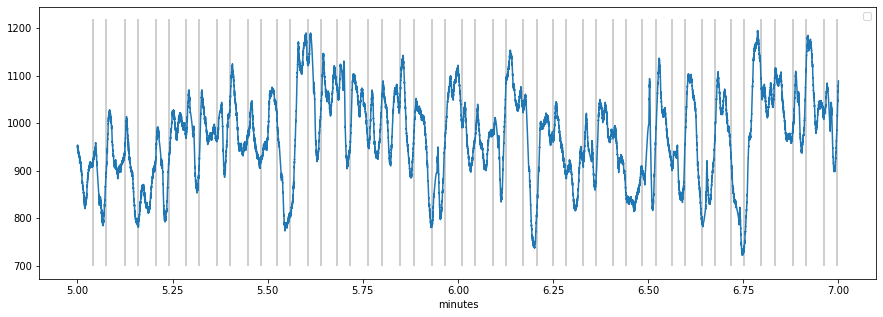

In [4]:
plt.figure(figsize=(15,5))
dat.plot(interactive=False, units="min");

# Data model

- pupil signal is made up of a slowly (<.1 Hz) fluctuating process
- and stereotypic responses to (internal or external):
    - Pupil-response function (PRF)
- the amplitude of the events is variable over time
- the shape of the PRF is fixed per subject or can vary over time

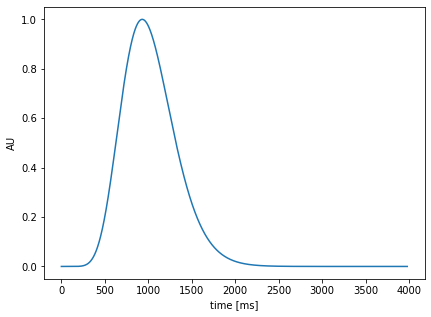

In [5]:
plt.figure(figsize=(15,5)); plt.subplot(1,2,1)
pp.plot_prf()

In [6]:
dd=pp.create_fake_pupildata(ntrials=100, isi=1500.0, rtdist=(1000,100))

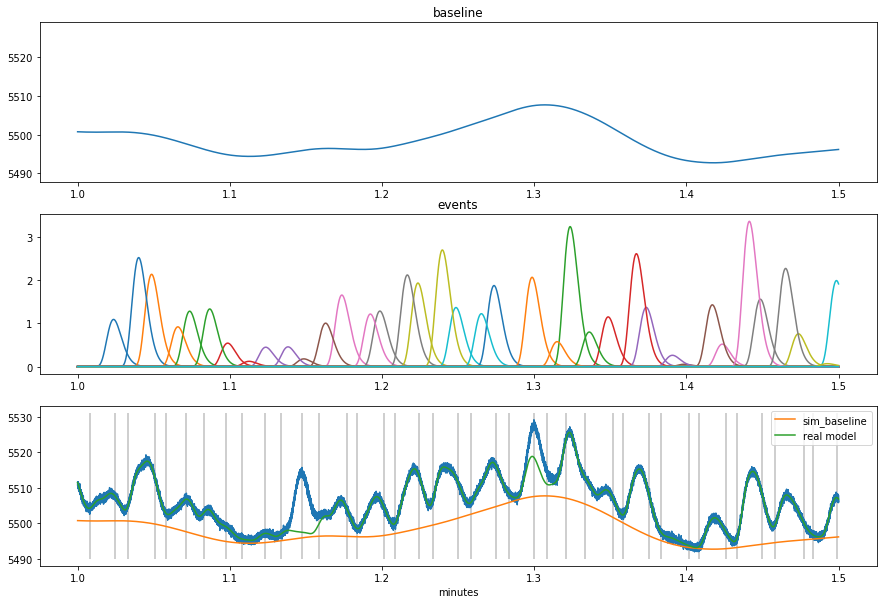

In [7]:
d=dd.sub_slice(start=1, end=1.5, units="min")

fac=d._unit_fac("min")
plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(d.tx*fac, d.sim_baseline); plt.title("baseline");
plt.ylim(d.sim_baseline.min()-5, d.sy.max())
plt.subplot(312)
x1=pp.pupil_build_design_matrix(d.tx, d.event_onsets, d.fs, d.sim_params["prf_npar"][0], d.sim_params["prf_tmax"][0], 6000)
plt.plot(d.tx*fac, d.sim_response_coef*x1.T); plt.title("events")
plt.subplot(313)
d.plot(interactive=False, units="min")

## Estimate tonic and phasic components

- per-trial estimates of tonic/phasic pupillary responses

*Traditionally:*
    
- tonic (baseline): mean signal in interval [-200,0] ms before stimulus
- phasic (response): 
    - difference peak/max in interval [0,2000] ms post-stimulus to baseline
    - difference mean in time-range of expected peak, e.g., [800,1200] ms post-stim to baseline

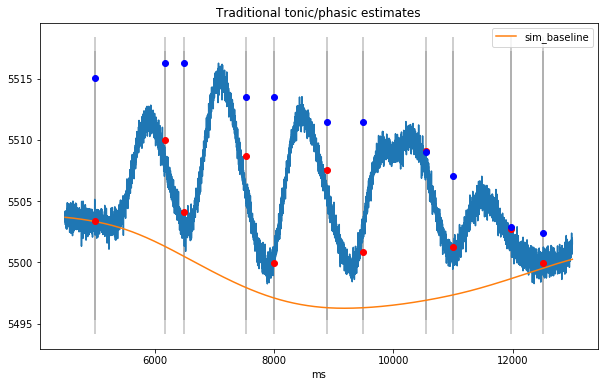

In [8]:
d2=dd.sub_slice(4500, 13000, units="ms") # take a small part for visualization


with io.capture_output() as cap:
    tonic_est =d2.stat_per_event((-200,0), statfct=np.mean)
    phasic_est=d2.stat_per_event((-0,2000), statfct=np.max)-tonic_est

plt.figure(figsize=(10,6))
d2.plot(model=False, units="ms")
plt.vlines(d2.event_onsets, *plt.ylim(), color="grey", alpha=0.5)
plt.plot(d2.event_onsets, tonic_est, "o",color="red")
plt.plot(d2.event_onsets, phasic_est+tonic_est, "o",color="blue");
plt.title("Traditional tonic/phasic estimates");

- traditional method can mistake build-up of responses for baseline fluctuations

## Novel Algorithm for baseline extraction

- in the absence of events, the pupil goes back to baseline
- therefore: throughs in the the curve are indicative of baseline 

**Algorithm:**
- detect throughs
- find the most "prominent" ones 
- create smooth curve through these points that stays below signal

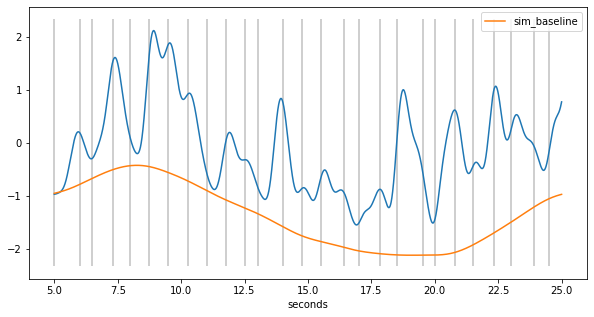

In [9]:
d=pp.create_fake_pupildata(ntrials=50, isi=1500.0, rtdist=(800,100),  
                           prop_spurious_events=0.02 )
d.lowpass_filter(cutoff=2)
d.scale()
d=d.sub_slice(5,25,units="sec")
plt.figure(figsize=(10,5)); d.plot(interactive=False, model=False, units="sec")

- lowest throughs are prioritized
- account for build-up of responses that look like baseline fluctuations

## Extract peaks/throughs and rate their prominence

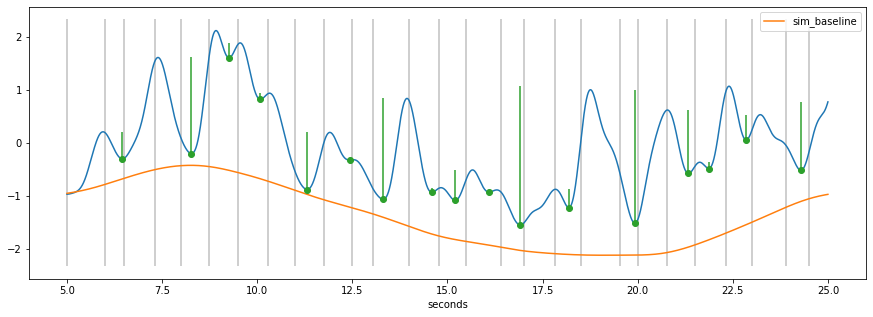

In [10]:
peaks_ix=signal.find_peaks(-d.sy)[0]
prominences=signal.peak_prominences(-d.sy, peaks_ix)[0]
peaks=d.tx[peaks_ix]
plt.figure(figsize=(15,5)); 
d.plot(model=False, units="sec")
plt.errorbar(peaks/1000., d.sy[peaks_ix], np.vstack((np.zeros_like(prominences), prominences)), 0, "o");

<https://en.wikipedia.org/wiki/Topographic_prominence>

## Smooth curve through peaks...


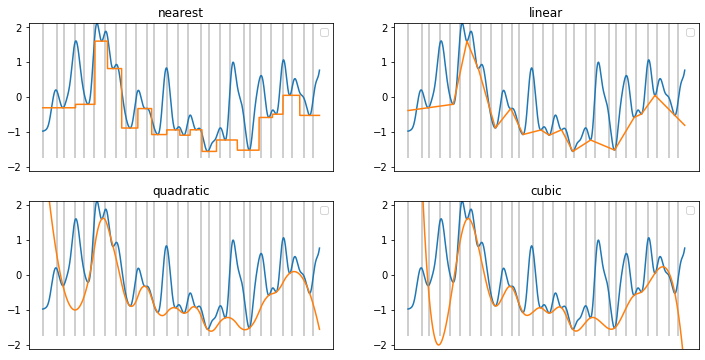

In [11]:
interp_methods=["nearest","linear","quadratic","cubic"]
plt.figure(figsize=(12,6))
for i,met in enumerate(interp_methods):
    plt.subplot(2,2,i+1)
    f=scipy.interpolate.interp1d(peaks, d.sy[peaks_ix], kind=met, fill_value="extrapolate")
    d.plot(baseline=False, model=False, units="ms")
    plt.plot(d.tx, f(d.tx))
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.ylim(d.sim_baseline.min(), d.sy.max())
    plt.title(met)

- simple interpolate between lower peaks?

## Better Solution: B-Spline basis functions
- weighted sum of B-spline basis functions (knots peaks): guarantees smoothness 
- customized fit to go through peaks and stay below signal

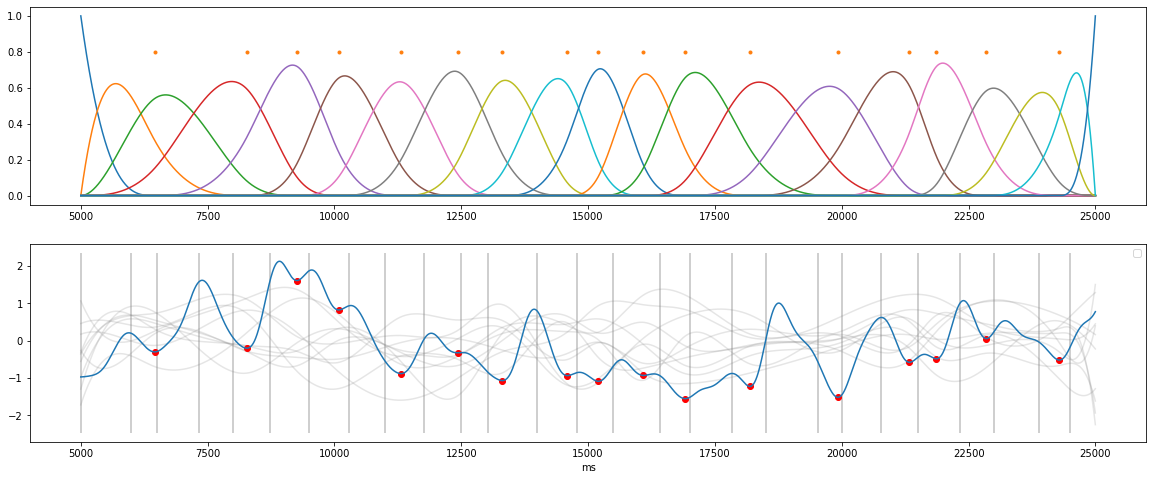

In [12]:
knots=np.concatenate( ([d.tx.min()], peaks, [d.tx.max()]) ) ## peaks as knots
B=pp.bspline(d.tx, knots, 3)

plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(d.tx, B);
plt.plot(peaks, 0.8+np.zeros_like(peaks), ".");
plt.subplot(2,1,2)

for i in range(10):
    coef=np.random.randn(B.shape[1])
    sig=np.dot(B,coef)
    plt.plot(d.tx, sig, color="grey", alpha=0.2)
plt.plot(peaks, d.sy[peaks_ix], "o", color="red")    
d.plot(simulated=False, units="ms");

## Staying "below the signal"

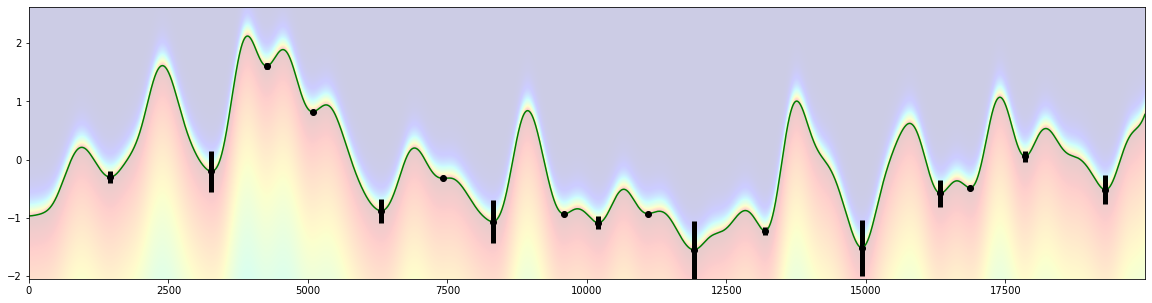

In [13]:
ny=800
x=d.tx
pad=0.5
y=np.linspace(d.sy.min()-pad, d.sy.max()+pad, ny)
[X,Y]=np.meshgrid(x,y)

SY=np.tile(d.sy, (ny,1))
py=pp.p_asym_laplac_kappa(-1*(Y-SY), 0, 1, 0.2)

def prominence_to_lambda(w, lam_min=1, lam_max=100):
        w2=lam_min+((w-np.min(w))/(np.max(w-np.min(w))))*(lam_max-lam_min)
        return w2
    
plt.figure(figsize=(20,5))
d2=d.copy()
start=d.tx[0]
d2.tx=d.tx-start
plt.imshow(py, origin='lower', cmap="jet", aspect="auto", alpha=0.2, extent=[0,d2.tx.max(),d2.sy.min()-pad, d2.sy.max()+pad])
plt.plot(d2.tx, d2.sy, color="green")
plt.errorbar(peaks-start, d2.sy[peaks_ix], yerr=prominence_to_lambda(prominences)/200., fmt="o", color="black", elinewidth=5);



- estimate coefficients B-spline
- criteria:
    1. the curve has to be (almost) completely below the pupil-signal
    2. it should go through the high-prominence peaks with high probability
    3. it should go through the lower-prominence peaks with lower probability
- use: Asymmetric Laplace distribution
- parameters: 
    - $\mu$ (peak location)
    - $\lambda$ (inverse variance, "wideness") 
    - $\kappa$ (assymetry parameter)

- distribution centered at signal $\rightarrow$ $\mu=0$
- set asymmetry parameter $\kappa$ as follows:
    1. specify the probability $p_a$ that the baseline-curve can take on values above the pupil signal, e.g., $p_a=0.05$
    2. using the properties of the distribution determine $$\kappa=\frac{\sqrt{p_a}}{\sqrt{1-p_a}}$$
- no matter what $\lambda$ is chosen, the negative part of the distribution will integrate to $p_a$

kappa= 0.22941573387056177
Proportion negative= 0.052898137321281825


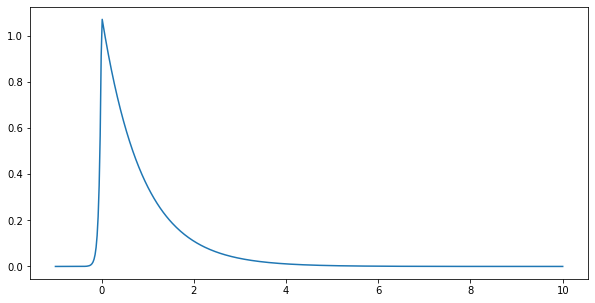

In [14]:
mu=0
lam=5
pa=0.05
kappa=np.sqrt(pa)/np.sqrt(1-pa)
print("kappa=",kappa)

plt.figure(figsize=(10,5))
y=np.linspace(-1,10,500)
py=pp.p_asym_laplac_kappa(y,0,5,kappa)
plt.plot(y,py)
propneg=np.sum(py[y<=0])/np.sum(py)
print("Proportion negative=",propneg)

### prominence of the peaks

- map the prominence of the peaks to the width of this distribution: 
    - mapping prominence $\rightarrow$ $\lambda$
- how far below the signal can the baseline go? parameter: $\lambda_{sig}$
- assume z-transformed PD, so 1 unit is pretty large: $\lambda_{sig}=1$
- for the highest-prominence peaks, the baseline-curve "snuggles" tightly against the signal
- $\lambda_{max}=100$

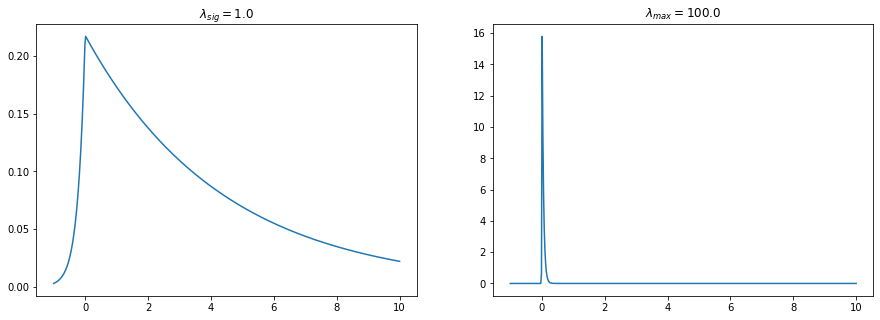

In [15]:
plt.figure(figsize=(15,5))
lam_sig=1.0
lam_max=100.0
y=np.linspace(-1,10,500)
py1=pp.p_asym_laplac_kappa(y,0,lam_sig,kappa)
py2=pp.p_asym_laplac_kappa(y,0,lam_max,kappa)
plt.subplot(121); plt.plot(y,py1); plt.title(r"$\lambda_{sig}=$%s"%lam_sig);
plt.subplot(122); plt.plot(y,py2); plt.title(r"$\lambda_{max}=$%s"%lam_max);

- the signal should be closer to the lower peaks than to the rest of the signal but can still go away if the prominence is very low
- we therefore set the lower boundary for $\lambda$ for any peak to be the same as for the rest of the signal $\lambda_{min}=\lambda_{sig}$
- define mapping 
$$\text{prominence}\rightarrow \lambda$$
- such that $\lambda \in [\lambda_{min},\lambda_{max}]$ and higher prominence is associated with higher $\lambda$
- we start by mapping the (strictly positive) prominence $\rho_i$ into the interval [0,1] and then map it linearly into $[\lambda_{min},\lambda_{max}]$
$$\lambda_i=\lambda_{min}+\frac{\rho_i-\min_i\rho_i}{\max_i(\rho_i-\min_i\rho_i)}\left(\lambda_{max}-\lambda_{min}\right) $$

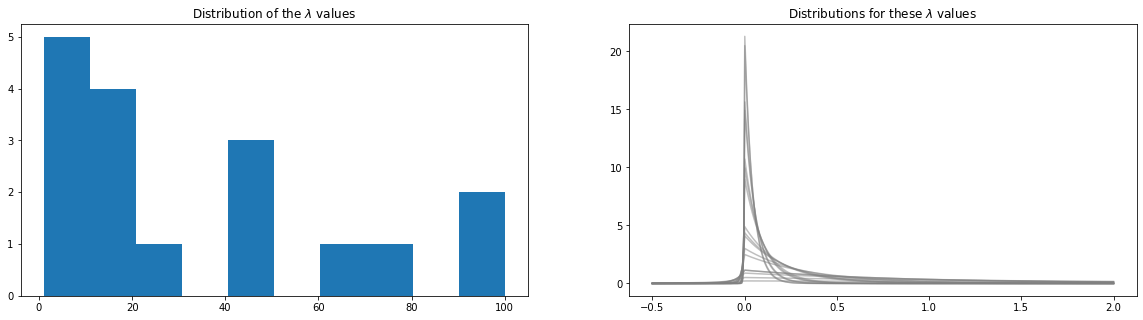

In [16]:
# convert
w=prominence_to_lambda(prominences)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(w);
plt.title(r"Distribution of the $\lambda$ values");
plt.subplot(122)
y=np.linspace(-0.5,2,500)
for i,cw in enumerate(w):
    py=pp.p_asym_laplac_kappa(y, 0, cw, kappa)
    plt.plot(y,py, color="grey", alpha=0.5)
plt.title(r"Distributions for these $\lambda$ values");

## Estimate baseline

- implemented as Bayesian model (Stan)
- free parameters are the spline-coefficients

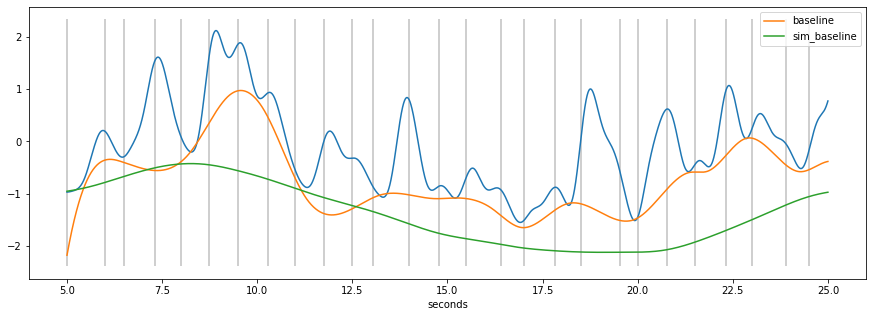

In [17]:
with io.capture_output() as cap: 
    d.estimate_baseline(method="envelope_iter_bspline_1")
plt.figure(figsize=(15,5)); d.plot(model=False)

- baseline seems to "high"
- because of accumulation of pupil-responses to stimuli
- **solution:** 
    1. estimate responses riding on top of signal 
    2. remove them
    3. repeat baseline estimation

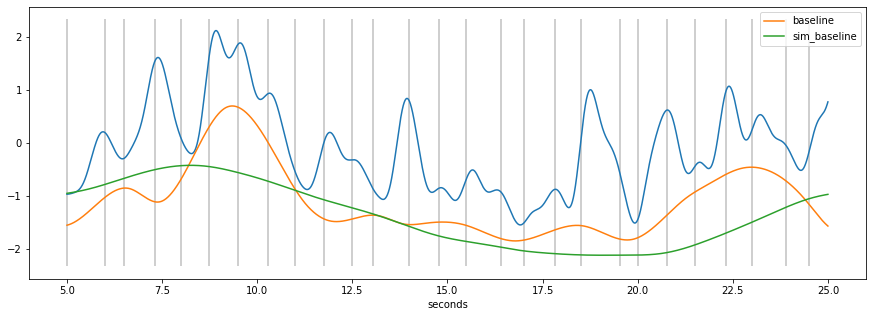

In [18]:
base1=d.baseline
with io.capture_output() as cap: 
    d.estimate_baseline(method="envelope_iter_bspline_2")
plt.figure(figsize=(15,5)); d.plot(model=False)
#plt.plot(d.tx, base1)

## Summary Algorithm baseline-extraction

1. find throughs in signal
2. rate them by prominence
3. create B-spline basis-functions at location of throughs
4. estimate B-coefficients using Bayesian model $\rightarrow$ first estimate for baseline
5. subtract baseline from signal
6. estimate response-model using default PRF and subtract from data
7. repeat steps 1. - 4. to get final baseline estimate

## Pupil-response function (PRF)

- Hoeks + Levelt, 1993 measured resonse to attentional stimulus

![huhu](stuff/hoeks_levelt_fig.png)

- model: $$h(t)=t^{n}e^{-nt/t_{max}}$$

### pupil-response function model: $h(t)=t^{n}e^{-nt/t_{max}}$

- parameters: location ($t_{max}$) and spread ($n$)

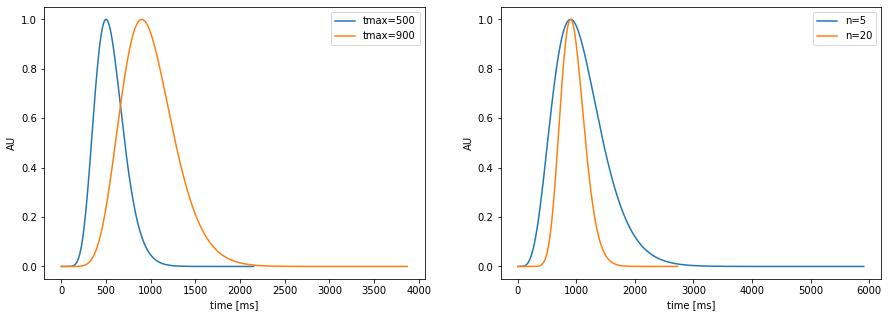

In [19]:
plt.figure(figsize=(15,5)); plt.subplot(1,2,1)
pp.plot_prf(npar=10, tmax=500,label="tmax=500")
pp.plot_prf(npar=10, tmax=900,label="tmax=900")
plt.legend();
plt.subplot(1,2,2)
pp.plot_prf(npar=5, tmax=900,label="n=5")
pp.plot_prf(npar=20, tmax=900,label="n=20")
plt.legend();

In [20]:
## data extract from original paper and saved in a CSV file
hl_data=pd.read_csv("stuff/tabula-Hoeks-Levelt1993_Article_PupillaryDilationAsAMeasureOfA.csv", sep=";")
hl_data["tmax"]=hl_data["tmax"]*1000. ## our implementation uses ms, HL use seconds
## between-subject variability
hl_per_subj=hl_data.groupby("subj").aggregate([np.mean,np.std])[["n","tmax"]]
hl_between=hl_per_subj.aggregate([np.mean,np.std]).filter(like="mean", axis=0)
hl_between

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


n             tmax            
           mean       std   mean         std
mean  10.340833  3.349051  917.0  135.357865

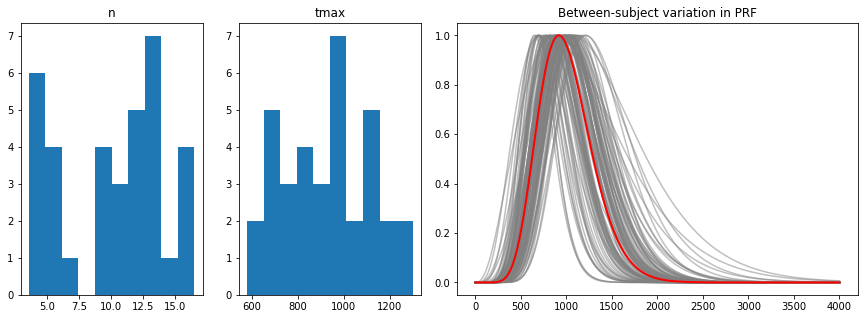

In [21]:
from matplotlib.gridspec import GridSpec


fig=plt.figure(figsize=(15,5))
gs = GridSpec(1, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2:4])

#plt.subplot(131)
ax1.hist(hl_data.n[hl_data.n.notnull()])
ax1.set_title("n")
#plt.subplot(132)
ax2.hist(hl_data.tmax[hl_data.tmax.notnull()]);
ax2.set_title("tmax");
#plt.subplot(133)

mn,sdn,mtmax,sdtmax=np.array(hl_between)[0]
nrep=100
duration=4000
fs=1000.
n=int(duration/1000*fs)
t = np.linspace(0,duration, n, dtype = np.float) # in ms

ns=np.random.randn(nrep)*sdn+mn
tmaxs=np.random.randn(nrep)*sdtmax+mtmax

#plt.figure(figsize=(10,5))
for i in range(nrep):
    h=pp.pupil_kernel(duration=duration, fs=fs, npar=ns[i], tmax=tmaxs[i])
    ax3.plot(t,h,color="grey", alpha=0.5)

h=pp.pupil_kernel(duration=duration, fs=fs, npar=mn, tmax=mtmax)    
ax3.plot(t,h,color="red",linewidth=2)
ax3.set_title("Between-subject variation in PRF");

## Signal modeled as sequence of responses (PRFs)

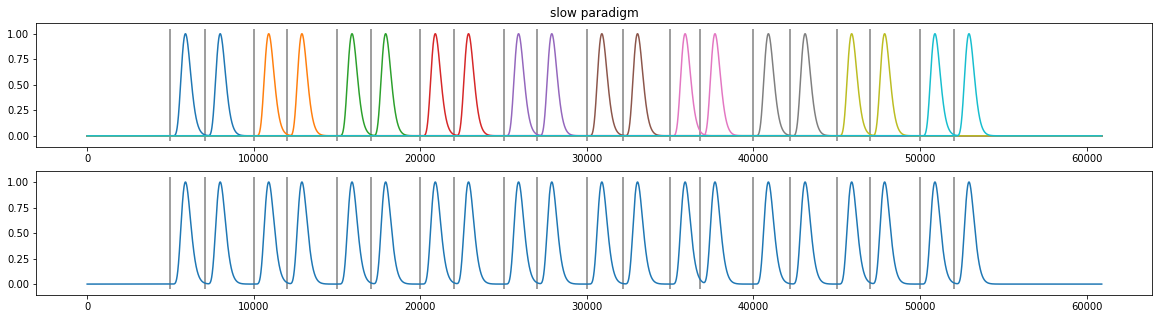

In [22]:
d3=pp.create_fake_pupildata(ntrials=10, isi=5000.0, rtdist=(2000,100))
X=pp.pupil_build_design_matrix(d3.tx, d3.event_onsets, d3.fs, 10, 900)
plt.figure(figsize=(20,5));
plt.subplot(211); plt.plot(d3.tx, X.T); plt.vlines(d3.event_onsets, *plt.ylim(), color="grey"); plt.title("slow paradigm");
plt.subplot(212); plt.plot(d3.tx, np.sum(X.T, axis=1)); plt.vlines(d3.event_onsets, *plt.ylim(), color="grey");

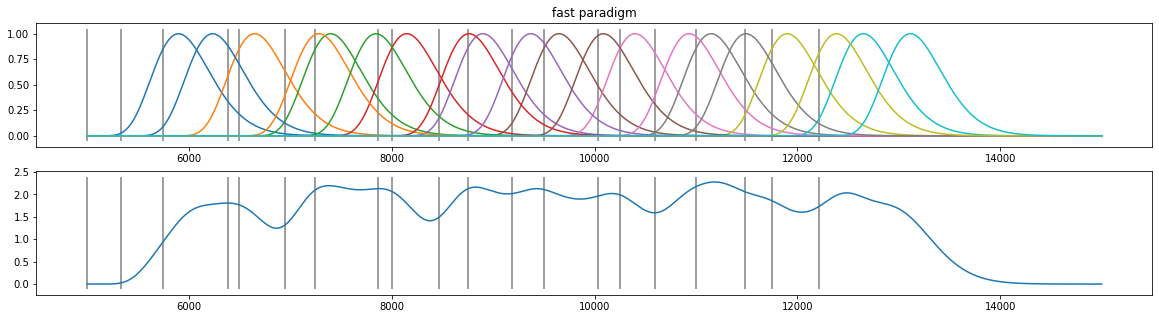

In [23]:
d4=pp.create_fake_pupildata(ntrials=10, isi=750.0, rtdist=(500,100))
d4=d4.sub_slice(5000, 15000, units="ms")
X=pp.pupil_build_design_matrix(d4.tx, d4.event_onsets, d4.fs, 10, 900)
plt.figure(figsize=(20,5));
plt.subplot(211); plt.plot(d4.tx, X.T); plt.vlines(d4.event_onsets, *plt.ylim(), color="grey"); plt.title("fast paradigm");
plt.subplot(212); plt.plot(d4.tx, np.sum(X.T, axis=1)); plt.vlines(d4.event_onsets, *plt.ylim(), color="grey");

## Assumptions

- shape of PRF constant for each person
- magnitude of the PRF varies by trial $\rightarrow$ target of this analysis

$\Rightarrow$ can we recover the magnitudes?


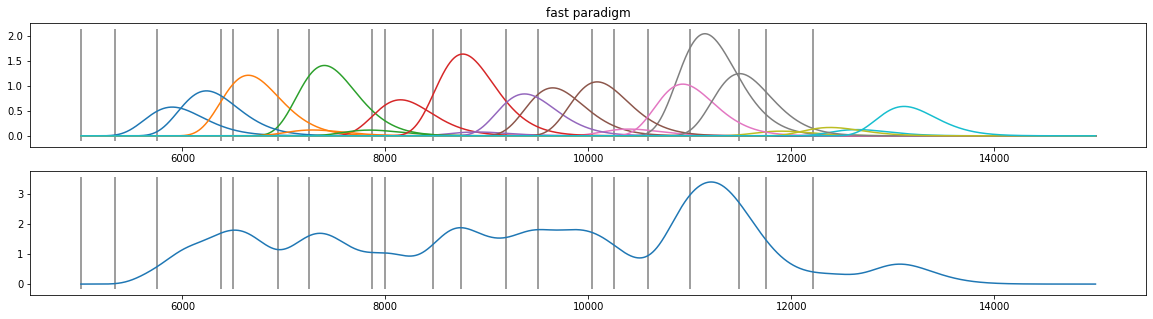

In [24]:
coef=np.abs( np.random.randn(d4.nevents()) )

plt.figure(figsize=(20,5));
plt.subplot(211); plt.plot(d4.tx, X.T*coef); plt.vlines(d4.event_onsets, *plt.ylim(), color="grey"); plt.title("fast paradigm");
plt.subplot(212); plt.plot(d4.tx, np.sum(X.T*coef, axis=1)); plt.vlines(d4.event_onsets, *plt.ylim(), color="grey");

In [40]:
d5=pp.create_fake_pupildata(ntrials=10, isi=750.0, rtdist=(500,100), prop_spurious_events=0)
#d5=d5.sub_slice(5,12,units="sec")
d5.lowpass_filter(cutoff=2)

d5.sy=d5.sy-d5.sim_baseline ## remove baseline for now
coef=d5.sim_response_coef   ## these are the simulated magnitudes

with io.capture_output() as cap:
    d5.estimate_response()
    naive_response=d5.stat_per_event([800,1200])-d5.stat_per_event([-200,0])

## Algorithm for estimating response

- build regressors

<center>
    <img src="stuff/pics/eyeglm_st.svg" width=90%>
</center>

- fit linear model

<center>
    <img src="stuff/pics/eyeglm2_st.svg" width=90%>
</center>

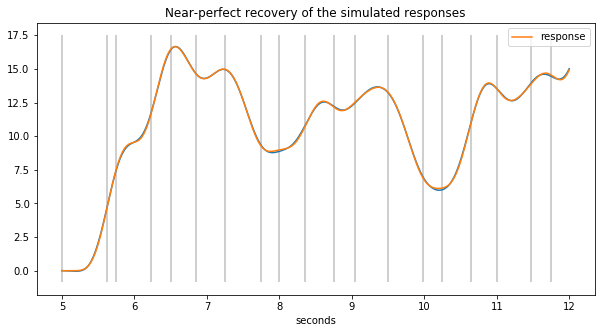

In [41]:
plt.figure(figsize=(10,5));
d5.plot((5, 12),simulated=False,response=True,units="sec")
plt.title("Near-perfect recovery of the simulated responses");

In [42]:
print("Correlation(real, new method) = %.2f"%pearsonr(coef, d5.response_pars["coef"])[0])

# compared to naive estimates
print("Correlation(real, traditional)= %.2f"%pearsonr(coef, naive_response)[0])

Correlation(real, new method) = 1.00
Correlation(real, traditional)= 0.37


## Baseline+Response estimation together...

for the naive estimator

In [45]:
d6=pp.create_fake_pupildata(ntrials=100, isi=750.0, rtdist=(300,100), prop_spurious_events=0)
d6.downsample(fsd=20)
d6.scale()

real_baseline=pp.stat_event_interval(d6.tx, d6.sim_baseline, d6.event_onsets, [0,0])
real_response=d6.sim_response_coef
naive_baseline=d6.stat_per_event([-200,0])
naive_response=d6.stat_per_event([800,1200])-naive_baseline

print("BL      : Correlation(real, traditional) = %.2f"%pearsonr(real_baseline, naive_baseline)[0])
print("Response: Correlation(real, traditional) = %.2f"%pearsonr(real_response, naive_response)[0])

BL      : Correlation(real, traditional) = 0.43
Response: Correlation(real, traditional) = 0.56


for the new method

In [46]:
with io.capture_output() as cap:
    d6.estimate_baseline()
    d6.estimate_response(npar=10.35, tmax=917)

    est_baseline=pp.stat_event_interval(d6.tx, d6.baseline, d6.event_onsets, [0,0])
    est_response=d6.response_pars["coef"]

print("BL      : Correlation(real, new method) = %.2f"%pearsonr(real_baseline, est_baseline)[0])
print("Response: Correlation(real, new method) = %.2f"%pearsonr(real_response, est_response)[0])

BL      : Correlation(real, new method) = 0.56
Response: Correlation(real, new method) = 0.86


In [48]:
d6.plot(interactive=True, simulated=True)

interactive(children=(FloatRangeSlider(value=(0.024500267742181423, 88.36446565862236), continuous_update=Fals…

## Validation of the method

- dependence of tonic/phasic recovery as a function of the tuning parameters of the algorithm
- robustness of method
    - against noise-level
    - against mis-specification (PRF pars)
    - against unknown "events"
- performance for different designs (ISI/RT)


## Validation

### setting tuning parameters

- scanning the tuning parameters for the B-Spline based baseline estimation
- `lam_sig` (float) - parameter steering how much the baseline is shaped by the non-peaks of the signal
- `lam_min`,`lam_max` (float) – parameters mapping how much low- and high-prominence peaks influence the baseline
- `niter` (1 or 2) - use 1 or two iterations of the procedure

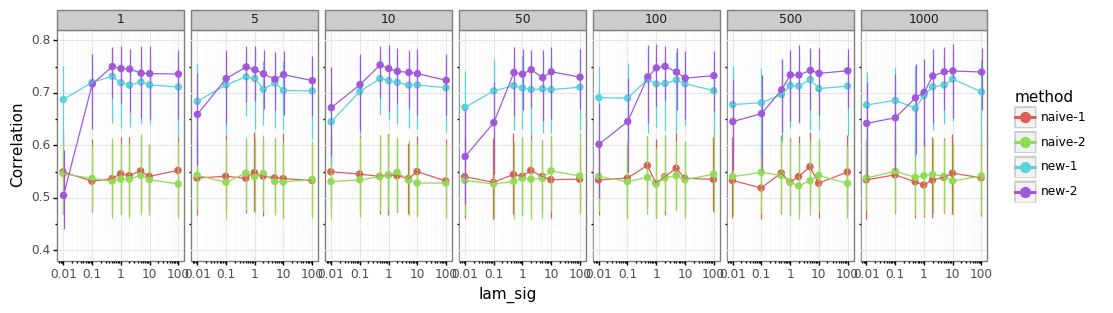

In [64]:
nbname="tonic_phasic_validation"
path="stuff/results/"
sim_label="tonic_phasic5"
fname=os.path.join(path,"{nb}_{sim}.ft".format(nb=nbname,sim=sim_label))
res=pd.read_feather(fname)
colnames=np.array(res.columns)[:-2]
df=pd.melt(res, id_vars=colnames, value_vars=["est_bl","naive_bl"])
df["estimate"]=["new" if "est" in v else "naive" for v in df.variable]
df["method"]=df[['estimate', 'niter']].astype(str).apply('-'.join, axis=1)
(gg.ggplot(df, gg.aes(x="lam_sig", y="value",color="method"))+
     gg.stat_summary(fun_y=np.median, 
                     fun_ymin=lambda y: np.mean(y)-np.std(y),#np.quantile(y,0.05),
                     fun_ymax=lambda y: np.mean(y)+np.std(y),#np.quantile(y,0.95), 
                     geom="pointrange", position=gg.position_dodge(.02))+
     gg.stat_summary(fun_y=np.median, geom="line", position=gg.position_dodge(.02))+
 gg.theme_bw()+
 gg.ylim(0.4,.8)+gg.ylab("Correlation")+gg.facet_grid("~lam_max")+
 gg.theme(figure_size=(12,3))+gg.scale_x_log10()
).draw();

- using 2 iterations generally better
- method works for a broad range of parameter-values
- getting `lam_sig` right is more important than `lam_max`

## Validation

### influence of design on performance

- manipulate experimental design parameters
    - proportion of "unknown" events
    - inter-stimulus interval (ISI)

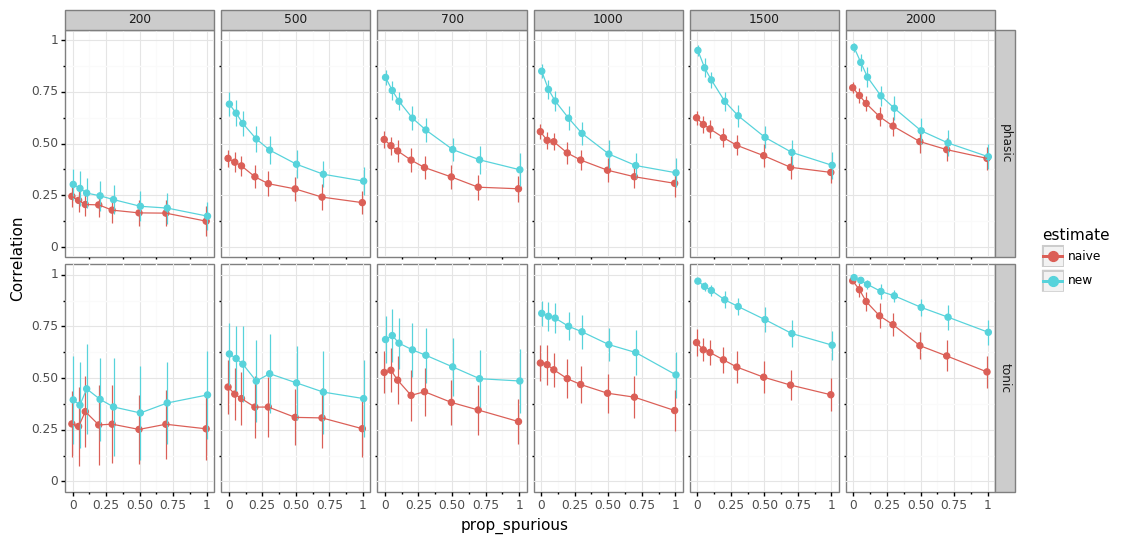

In [75]:
sim_label="tonic_phasic1"
fname=os.path.join(path,"{nb}_{sim}.ft".format(nb=nbname,sim=sim_label))
res=pd.read_feather(fname)
colnames=np.array(res.columns)[:-4]
df=pd.melt(res, id_vars=colnames, value_vars=["est_bl","est_resp","naive_bl","naive_resp"])
df["tonic_phasic"]=["tonic" if "bl" in v else "phasic" for v in df.variable]
df["estimate"]=["new" if "est" in v else "naive" for v in df.variable]
(gg.ggplot(df, gg.aes(x="prop_spurious", y="value",color="estimate"))+
     gg.stat_summary(fun_y=np.median, 
                     fun_ymin=lambda y: np.median(y)-np.std(y),#np.quantile(y,0.05),
                     fun_ymax=lambda y: np.median(y)+np.std(y), #np.quantile(y,0.95), 
                     geom="pointrange", position=gg.position_dodge(.02))+
     gg.stat_summary(fun_y=np.median, geom="line", position=gg.position_dodge(.02))+
 gg.theme_bw()+
 gg.ylim(0,1)+gg.ylab("Correlation")+gg.facet_grid("tonic_phasic~isi")+
 gg.theme(figure_size=(12,6))
).draw();

## Validation

### influence of misspecification

- simulate data with a set of `npar`/`tmax` parameters (this is what is being manipulated)
- recover using standard "wrong" pars (those are fixed, i.e., using the mean only)

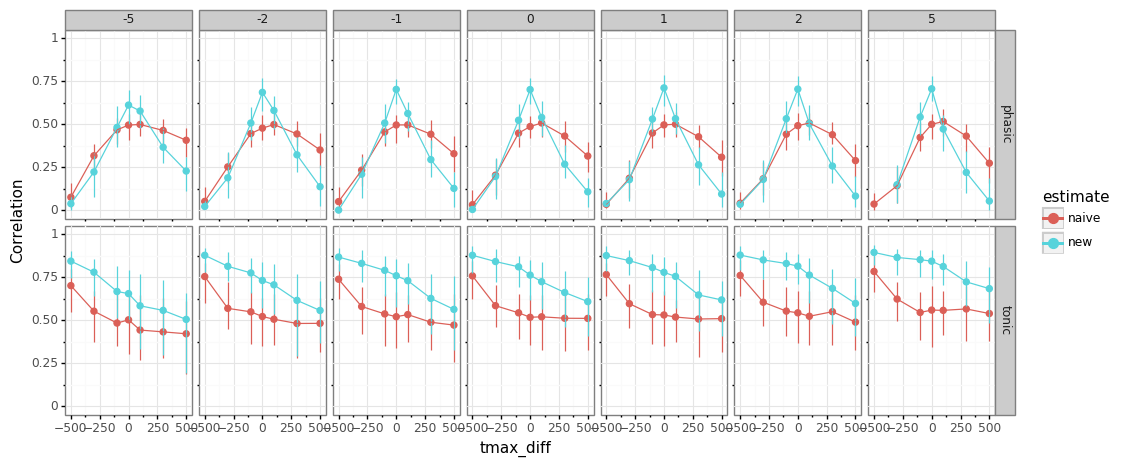

In [80]:
sim_label="tonic_phasic2"
fname=os.path.join(path,"{nb}_{sim}.ft".format(nb=nbname,sim=sim_label))
res=pd.read_feather(fname)
colnames=np.array(res.columns)[:-4]
df=pd.melt(res, id_vars=colnames, value_vars=["est_bl","est_resp","naive_bl","naive_resp"])
df["tonic_phasic"]=["tonic" if "bl" in v else "phasic" for v in df.variable]
df["estimate"]=["new" if "est" in v else "naive" for v in df.variable]
(gg.ggplot(df, gg.aes(x="tmax_diff", y="value",color="estimate"))+
     gg.stat_summary(fun_y=np.median, 
                     fun_ymin=lambda y: np.quantile(y,0.05),
                     fun_ymax=lambda y: np.quantile(y,0.95), geom="pointrange", position=gg.position_dodge(.02))+
     gg.stat_summary(fun_y=np.median, geom="line", position=gg.position_dodge(.02))+
 gg.theme_bw()+
 gg.ylim(0,1)+gg.ylab("Correlation")+gg.facet_grid("tonic_phasic~npar_diff")+
 gg.theme(figure_size=(12,5))
).draw();

- `npar` - misspecification does not matter much
- `tmax` important to get right, both for traditional and new method
- shorter pulses (low `tmax`) beneficial for baseline-estimation (less build-up)

## Validation

### compensate for misspecation 

- is it possible to compensate for `tmax`-misspecification by estimating `tmax` from data?

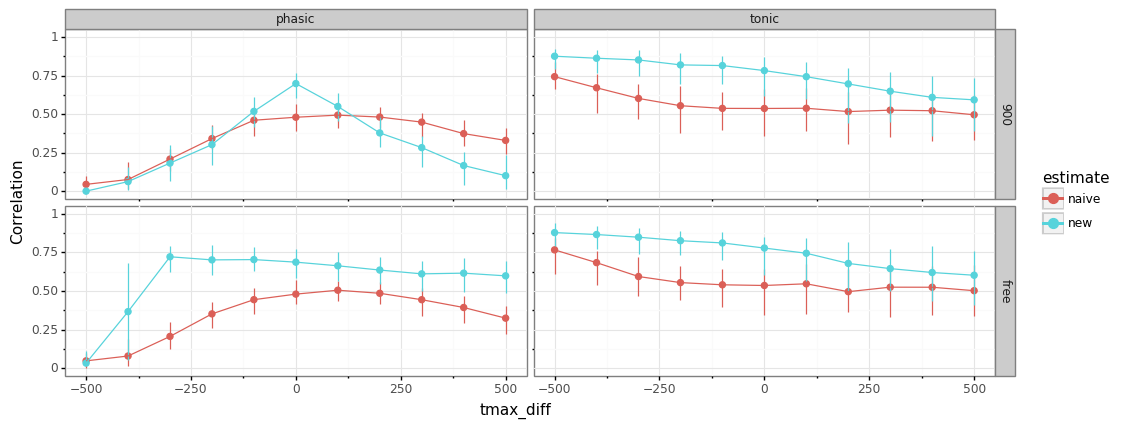

In [85]:
sim_label="tonic_phasic4"
fname=os.path.join(path,"{nb}_{sim}.ft".format(nb=nbname,sim=sim_label))
res=pd.read_feather(fname)
colnames=np.array(res.columns)[:-4]
df=pd.melt(res, id_vars=colnames, value_vars=["est_bl","est_resp","naive_bl","naive_resp"])
df["tonic_phasic"]=["tonic" if "bl" in v else "phasic" for v in df.variable]
df["estimate"]=["new" if "est" in v else "naive" for v in df.variable]
(gg.ggplot(df, gg.aes(x="tmax_diff", y="value",color="estimate"))+
     gg.stat_summary(fun_y=np.median, 
                     fun_ymin=lambda y: np.quantile(y,0.05),
                     fun_ymax=lambda y: np.quantile(y,0.95), geom="pointrange", position=gg.position_dodge(.02))+
     gg.stat_summary(fun_y=np.median, geom="line", position=gg.position_dodge(.02))+
 gg.theme_bw()+
 gg.ylim(0,1)+gg.ylab("Correlation")+gg.facet_grid("tmax_fit~tonic_phasic")+
 gg.theme(figure_size=(12,4.5))
).draw();

- estimating `tmax` allows broader range of misspecification
- SD for `tmax` from Hoeks & Levelt (1997) was 135 ms, so feasible range should cover most subjects


### Future directions

- validate method on real data
- include auto-correlation for response-estimation?
- trial-by-trial variations for the PRF-parameters?
- include pupillary hippus (stronger tonic fluctuations at low baseline levels)

## Thank you for your attention!

<img src="stuff/pics/Screenshot 2020-02-05 at 13.00.15.png" width=50%>

- all functions implemented in Python-package `pypillometry`: <https://ihrke.github.io/pypillometry>

## old/additional slides

## Notes/Ideas

- calculate relationship bw pupil and MW (based on old dataset or simsart or FT-RNGT) and see whether it gets stronger with the better algorithm
- 

## Estimate phasic response


- Hoeks and Levelt (1993):
$$
h_{HL}(t) = t^n e^{-nt/t_{max}}
$$
which we normalize to
$$
h(t)=\frac{1}{h_{max}} h_{HL}(t) 
$$
where 
$$
h_{max} = \max_t{\left(h_{HL}(t)\right)} = e^{-n}t_{max}^{n}
$$
- they report estimates for $n$ and $t_{max}$ for 8 subjects and 6 conditions per subject
- estimate both between-subject and within-subject variation